# Forecasting Cases and Lockdowns

The aim of this project is to plan holidays and life around lockdown by predicting when NSW lockdown will cease. There is a time series dataset of [cases](https://data.nsw.gov.au/nsw-covid-19-data/cases) available through open data NSW and a website which has key [summaries of announcements](https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp2021/Chronologies/COVID-19StateTerritoryGovernmentAnnouncements).
<br>  
The model will predict the confidence across a range of dates, and the visible output will be a probability distribution across a 2 week period with the mid date being the most likely date.
<br>  
The model will be retrained daily, in the afternoon once the daily case data and new announcements have come in.
<br>  
The data will be available through a streamlit dashboard with the Date clearly visible and a plotly graph showing the probabilities.


Ideas:  
- probability of compliance with stay at home orders


Ideas:
- Look at optimal placement of vaccination centres based on population, cases, transmission rates and severe cases

In [3]:
!pip install plotly
conda install -c conda-forge nbformat

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
  Using cached plotly-5.1.0-py2.py3-none-any.whl (20.6 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [255]:
!pip install pytrends

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [148]:
import requests, json, logging, errno, os
from typing import List
from datetime import datetime, timedelta
from pathlib import Path

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
# from prophet import? Prophet

# Vis libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

In [337]:
from pytrends.request import TrendReq
from pytrends import dailydata

In [311]:
def plot_dataset(df: pd.DataFrame, col: str, title: str = '', overlay: bool = False, overlay_col: str = None):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df[col],
        mode="lines",
        name="count",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(207,0,15, 0.7)"),
    )
    data.append(value)

    if overlay:
        ann_df = df[~df[overlay_col].isna()]
        announcements = go.Scatter(
            x=ann_df.index,
            y=ann_df[overlay_col],
            mode='markers',
            name='media announcements',
            text=ann_df[overlay_col],
            textposition="top right",
            textfont=dict(
                family="sans serif",
                size=6,
                color="crimson"
            ),
            line=dict(color="rgba(0,207,15, 1.0)")
        )
        data.append(announcements)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Count", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

## 1. Load

### 1.1 Load Case Data

In [410]:
def get_case_data(from_csv: bool = True) -> pd.DataFrame:
    """Loads data from data nsw and in future, other data sources."""
    
    
    if from_csv:
        return load_case_data()
    
    def get_data_nsw(resource_id: str, counts_col: str = None) -> pd.DataFrame:
        """Retrieve json data object and convert to pandas dataframe"""
    
        # Query API
        url = f'https://data.nsw.gov.au/data/api/3/action/datastore_search?resource_id={resource_id}&limit=100000'  
        res = requests.get(url)
        records = res.json()['result']['records']

        # Convert to dataframe
        df = pd.DataFrame(records)
        
        # Set date as index and standardise name
        df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
        df.set_index(df.columns[0], inplace=True)
        df.index.rename('date', inplace=True)
        
        # Get daily values by either summing counts col or counting rows
        if counts_col in df.columns:
            df = df[counts_col]
            df = df.astype('int')
        else:
            df['count'] = 1
            df = df['count']
        
        df = df.groupby(pd.Grouper(level='date', freq='D')).sum()
        
        return df
    
    # resource IDS for data nsw APIs 
    resource_ids = {
        'testing': '945c6204-272a-4cad-8e33-dde791f5059a',
        'cases': '21304414-1ff1-4243-a5d2-f52778048b29'
    }
    
    df = get_data_nsw(resource_ids['cases']).to_frame()

    print(f'{df.index.min()} - {df.index.max()}')
    df.to_csv('data/case_data.csv')
    return df

def load_case_data() -> pd.DataFrame:
    df = pd.read_csv('data/case_data.csv')
    df.set_index('date', inplace=True)
    return df

### 1.2 Load News from NSW Gov

In [411]:
def get_news_data(from_csv: bool = True) -> pd.DataFrame:
    """Gathers relevant text data from government site"""

    if from_csv:
        return load_news_data()
    
    url = 'https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp2021/Chronologies/COVID-19StateTerritoryGovernmentAnnouncements'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    tables = soup.findAll('table')
    table = tables[4]
    table_rows = table.find_all('tr')

    res = []
    for tr in table_rows:
        td = tr.find_all('td')
        row = [tr.text.strip() for tr in td if tr.text.strip()]
        if row:
            res.append(row)
    clean_res = [r for r in res if len(r) == 3]
    df = pd.DataFrame(clean_res[1:], columns=clean_res[0])
    df.columns = ['date', 'content', 'references']
    df.date = pd.to_datetime(df.date)
    
    # test_str = nsw_announcements.references.tolist()[7]
    references_list = []
    # for r in nsw_announcements.references.tolist():
    def clean_references(x: str) -> str:
        split_str = ' '.join(x.split()).split(',')
        # peoples names exist
        if len(split_str) == 5:
            # Concatetenate the first and second
            split_str = [split_str[0] + split_str[1]] + split_str[2:]
        if len(split_str) == 3:
            split_str.append(None)
        return split_str

    references_df = pd.DataFrame(df.references.apply(clean_references).tolist())
    references_df.columns = ['source', 'theme', 'medium', 'date_released']
    df = pd.concat([df.drop(columns='references'), references_df], axis=1, join='inner')
    df.set_index('date', inplace=True)
    df.to_csv('data/nsw_announcements.csv')
    assert len(df) > 5
    return df

def load_news_data() -> pd.DataFrame:
    df = pd.read_csv('data/nsw_announcements.csv')
    df.set_index('date', inplace=True)
    return df

### 1.3 Load Google Trend Data

In [412]:
def get_google_trend_data(from_csv: bool = True, to_month: int = 7) -> pd.DataFrame:
    """Extract google trend data about the lockdown"""

    
    if from_csv:
        return load_google_trend_data()
    
    print('This will take a minute or two...')
    df = dailydata.get_daily_data('covid', 2020, 2, 2021, to_month, geo = 'AU-NSW')
    df.to_csv('data/google_trend_covid.csv')
    print('data saved')
    return df

def load_google_trend_data() -> pd.DataFrame:
    df = pd.read_csv('data/google_trend_covid.csv')
    df.set_index('date', inplace=True)
    return df

### 1.4 Load Dates of Restrictions

In [413]:
def get_restrictions_data(from_csv: bool = True) -> pd.DataFrame:
    """Restrictions in place from 
        https://www.theguardian.com/world/2020/may/02/australias-coronavirus-lockdown-the-first-50-days
        https://deborahalupton.medium.com/timeline-of-covid-19-in-australia-1f7df6ca5f23
    """
    if from_csv:
        return load_restrictions_data()
    
    lockdown_dates_nsw = [
        ['2020-03-16', 500], # gatherings over 500 forbidden
        ['2020-03-18', 100], # gatherings over 100 forbidden
        ['2020-03-19', 50], # gathering over 50 forbidden
        ['2020-03-24', 10], # gatherings over 10 forbidden
        ['2020-03-27', 5], # exercise groups limited to 10 and no seeing others
        ['2020-03-29', 2], # no more then two 
        ['2020-03-30', 1], # $1000 fines enfored and ph orders
        ['2020-04-29', 2], # can visit family
        ['2020-05-01', 10], # restrictions loosen, family picnic and park, 50km radius of home
        ['2020-05-08', 15] # three stage plan announced
    ]
    # Convert to dataframe
    df = pd.DataFrame(lockdown_dates_nsw, columns=['date', 'restriction'])
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True)

    # Impute dates with last date
    df = df.resample('D').mean() # Mean is irrelevant in this case
    df = df.fillna(method='ffill')
    
    # Invert the restriction value to make higher = worse
    df['severity'] = df.restriction.apply(lambda x: int((1/x)*100))
    df.to_csv('data/restrictions.csv')
    return df

def load_restrictions_data() -> pd.DataFrame:
    df = pd.read_csv('data/restrictions.csv')
    df.set_index('date', inplace=True)
    return df

### 1.4 Load & Join Datasets

In [416]:
def get_data(from_csv: bool = True) -> pd.DataFrame:
    """
    Builder function to gather all the data and join it
    If the data has not been imputed, i.e for news df
    then the column will contain none, and there will be
    a complementary binary column for the existance 
    """
    
    cases_df = get_case_data(from_csv)
    print('cases data loaded')
    news_df = get_news_data(from_csv)
    print('news data loaded')
    trend_df = get_google_trend_data(from_csv)
    print('google trend data loaded')
    restric_df = get_restrictions_data(from_csv)
    print('restrictions data loaded')
    
    df = cases_df.join(news_df, how='left').join(trend_df, how='left')
#     df.head()
#     gt_df = load_trend_data(True)
#     gt_df = gt_df[['covid_unscaled']]
#     gt_df.columns = ['count']
#     plot_dataset(gt_df, 'count', 'Google References to "covid"')
    
    return pd.DataFrame()

get_data(True)

cases data loaded
news data loaded
google trend data loaded
restrictions data loaded


""


In [344]:
plot_dataset(df[df.index <'2020-07-01'], 'count', 'NSW COVID19 Cases')

KeyError: 'NSW COVID19 Cases'

## Preprocessing

In [196]:
def clean_text(text: str) -> str:
    cleaned = ' '.join(text.split())
    
    return cleaned

def add_noise(content: pd.Series) -> pd.Series:
    pass

def clean_all_text() -> pd.Series:
    pass

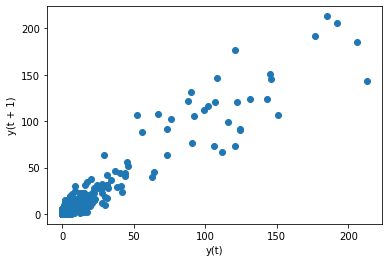

In [4]:
pd.plotting.lag_plot(df)
plt.show()

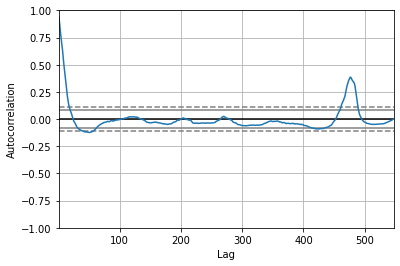

In [5]:
pd.plotting.autocorrelation_plot(df)
plt.show()

The only data we care about is the 

In [197]:
nsw_announcements = load_scraped()
nsw_announcements.head()

,content,source,theme,medium,date_released
date,,,,,
2020-01-21,NSW Health announced that it would assist\n ...,NSW Ministry of Health NSW Health advice to tr...,China,media release,21 January 2020.
2020-01-25,NSW Health released information that five\n ...,NSW Ministry of Health,Novel coronavirus statistics—11 am,media release,25 January 2020.
2020-02-06,NSW Health released a statement in\n ...,NSW Ministry of Health Be aware of the symptoms,be wary of false reports,media release,6 February 2020.
2020-02-10,The Minister for Health announced that a\n ...,B Hazzard (NSW Minister for Health),NSW researchers breakthrough on coronavirus,media release,10 February 2020.
2020-02-13,NSW Health released an update on the four\n ...,NSW Ministry of Health,Fourth coronavirus case in NSW now in the clear,media release,13 February 2020.


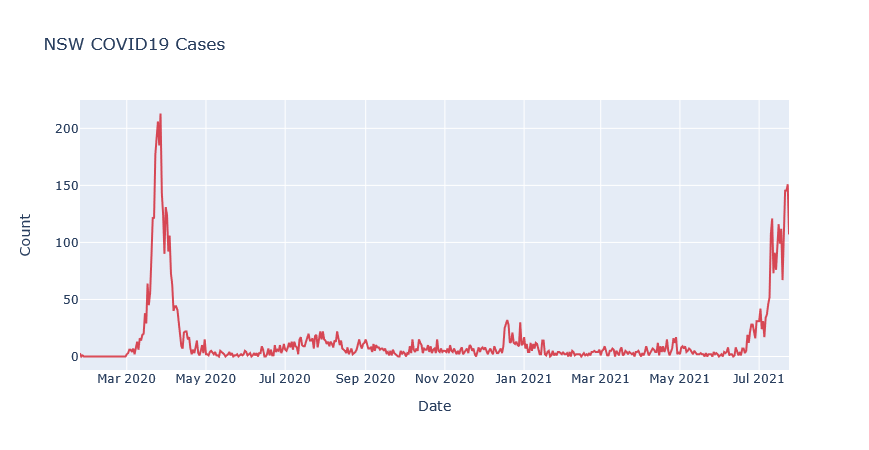

In [200]:
plot_dataset(df, 'NSW COVID19 Cases')

In [ ]:
[
    ['border_restriction', '2020-']
]

In [16]:
df[(df.index > '2020-01') & (df.index > '2020-')]

,count
date,
2020-01-25,3
2020-01-26,0
2020-01-27,1
2020-01-28,0
2020-01-29,0
...,...
2021-07-20,108
2021-07-21,146
2021-07-22,145


## 2. Transform

In [23]:
from abc import ABC, abstractmethod
from sklearn.preprocessing import MinMaxScaler

class TSTransformer(ABC):
    
    transformer_name = None
    transform_data_path = Path(f'data/transformed_{transformer_name}_data.csv')
        
    @abstractmethod
    def transform_data(self, ts_df: pd.DataFrame, input_dim: int = 0) -> pd.DataFrame:
        pass
    
    def load_transformed_data(self) -> pd.DataFrame:
        
        return pd.read_csv(self.transform_data_path, index_col='date')
    
    def generate_time_lags(self, df, n_lags):
        df_n = df.copy()
        for n in range(1, n_lags + 1):
            df_n[f'lag{n}'] = df_n['count'].shift(n)

        # Remove variables that are represented by the lag
        df_n = df_n.iloc[n_lags:]

        return df_n
    
    def scale_data(self, df, scaler) -> pd.DataFrame():
        df_ = df.copy()
        # TOOO:
        return df_
    
    
class MultiVariateTransformer(TSTransformer):
    
    def __init__(self):
        self.transformer_name = 'multivariate'
#     transform_data_path = Path(f'data/transformed_{self.transformer_name}_data.csv')

    def transform_data(self, ts_df: pd.DataFrame, input_dim: int = 0) -> pd.DataFrame:
        """Encapsulates the transformations done in preparation of the modelling"""
        
        df = ts_df.copy()
    
#         scaler = MinMaxScaler()
#         df = scaler.fit_transform(df)
        
        # Predict out 30 days
        df = self.generate_time_lags(df, 30)

        # Generate features from the date
        df_features = (
                    df
                    .assign(hour = df.index.hour)
                    .assign(day = df.index.day)
                    .assign(month = df.index.month)
                    .assign(day_of_week = df.index.dayofweek)
                    .assign(week_of_year = df.index.week)
                  )

        def onehot_encode_pd(df, col_name):
            """One hot encode the date features"""
            for col in col_name:
                df[col] = df[col].astype('object')
            dummies = pd.get_dummies(df[col_name], prefix=col_name)
            return pd.concat([df, dummies], axis=1).drop(col_name, axis=1)

        df.to_csv(self.transform_data_path)
        return df_features


class ARTransformer(TSTransformer):
    """Performs transformations for an autoregressive model. Particularly excludes extracting date data (day of week, week etc)"""
    def __init__(self):
        self.transformer_name = 'autoregressive'
#     self.transform_data_path = Path(f'data/transformed_{self.transformer_name}_data.csv')
        
    def transform_data(self, ts_df: pd.DataFrame, input_dim: int=0) -> pd.DataFrame:
        
        df_features = pd.DataFrame()
        
        return df_features

In [24]:
# transformer = MultiVariateTransformer()

transformer = MultiVariateTransformer()

df_transformed = transformer.transform_data(df, 100)
print(df_transformed.shape)
print(f'Date Coverage: {df_transformed.index.min()} - {df_transformed.index.max()}')

(517, 36)
Date Coverage: 2020-02-24 00:00:00 - 2021-07-24 00:00:00


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [151]:
# df_transformed[['count', 'lag100']].plot()

## 3. Model

### Prophet for a statistical approach

### Deep Learning because DL..

In [152]:
# plot_dataset(df, 'Daily COVID Cases In NSW')

### Split Data
We want to make predictions based on the most recent lockdown which started at approximately June 26th. We will try different splits

In [153]:
from sklearn.model_selection import train_test_split
from datetime import date

In [154]:
def split(df_tosplit: pd.DataFrame, target: str = 'count', split_on: date = None, test_ratio: float = .2) -> ():
    """Split data into train, test and validation using a date or ratio"""
    
    X = df_tosplit.copy()
    y = X.pop(target)
    
    val_ratio = .35#test_ratio / (1 - test_ratio)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    
    
    return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = split(df_transformed)

In [155]:
# plot_dataset(y_train.to_frame(), "Training Data")

In [156]:
# plot_dataset(y_test.to_frame(), "Test Data")

In [157]:
# plot_dataset(y_val.to_frame(), "Validation Data")

# Checkpoint

In [159]:
# Save and load methods for processed data
def save_processed_files(X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr):
    """Save files to processed directory in a standard fashion"""
    processed_path = Path('data/processed')
    np.savetxt(processed_path / 'X_train.csv', X_train_arr, delimiter=',')
    np.savetxt(processed_path / 'X_val.csv', X_val_arr, delimiter=',')
    np.savetxt(processed_path / 'X_test.csv', X_test_arr, delimiter=',')

    np.savetxt(processed_path / 'y_train.csv', y_train_arr, delimiter=',')
    np.savetxt(processed_path / 'y_val.csv', y_val_arr, delimiter=',')
    np.savetxt(processed_path / 'y_test.csv', y_test_arr, delimiter=',')
    
save_processed_files(X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr)

In [160]:
def load_processed_files():
    """Load numpy arrays used to train models"""
    processed_path = Path('data/processed')
    
    print([p.name for p in processed_path.iterdir()])
    try:
        X_train_arr = np.loadtxt(processed_path / 'X_train.csv', delimiter=',')
        X_val_arr = np.loadtxt(processed_path / 'X_val.csv', delimiter=',')
        X_test_arr = np.loadtxt(processed_path / 'X_test.csv', delimiter=',')
        
        y_train_arr = np.loadtxt(processed_path / 'y_train.csv', delimiter=',')
        y_val_arr = np.loadtxt(processed_path / 'y_val.csv', delimiter=',')
        y_test_arr = np.loadtxt(processed_path / 'y_test.csv', delimiter=',')
    except Exception as e:
        print("Failed to load files, maybe doesn't exist?")
        print(e)
        
    return X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr

X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr = load_processed_files()

['y_train.csv', 'X_val.csv', 'y_test.csv', 'X_test.csv', 'y_val.csv', 'X_train.csv']


In [161]:
# Quick check to make sure they look correct
print(X_train_arr.shape, X_val_arr.shape, y_train_arr.shape)

(50, 455) (27, 455) (50,)


## Model 1: RNN

In [162]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [163]:
batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [164]:
class RNNModel(nn.Module):
    """Vanilla RNN Model"""
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        
        super(RNNModel, self).__init__()
        
        # Define number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # RNN Layers
        self.rnn = nn.RNN(
        input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        print(h0.shape)
        # Forward prop by passing input and hidden state into model
        out, h0 = self.rnn(x, h0.detach())
        
        # Reshape outputs into (batch_size, seq_length, hidden_size)
        out = out[:, -1, :]
        
        # Convert final state to output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [165]:
class LSTMModel(nn.Module):
    """LSTM Model"""
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [166]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [167]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [168]:
from datetime import datetime

In [169]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        # Set model to train mode
        self.model.train()
        
        # Predict
        yhat = self.model(x)
        
        # Compute loss
        loss = self.loss_fn(y, yhat)
        
        # Compute gradients
        loss.backward()
        
        # Update params and zero grads
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size: int = 64, n_epochs: int = 50, n_features: int = 1) -> None:
        """Trains the model in mini batches for n epochs"""
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        # Epoch Iteration
        for epoch in range(1, n_epochs+1):
            batch_losses = []
            
            # Mini Batch Iterations
            for x_batch, y_batch in train_loader:
                # Send tensors to device
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device) # TODO: setup device?
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
                
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            # Evaluation
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if (epoch <= 10) | (epoch %50 == 0):
                print(
                    f'[{epoch}/{n_epochs}] Training Loss: {training_loss:.4f}\t Validation Loss: {validation_loss:.4f}'
                )
            torch.save(self.model.state_dict(), model_path)
            
            
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            preds = []
            vals = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                
                self.model.eval()
                yhat = self.model(x_test)
                preds.append(yhat.to(device).detach().numpy())
                vals.append(y_test.to(device).detach().numpy())
                
        return preds, vals
                
        
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [170]:
import torch.optim as optim

In [171]:
len(X_train.columns), X_train_arr.shape[1]

(455, 455)

In [172]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



[1/100] Training Loss: nan	 Validation Loss: nan
[2/100] Training Loss: nan	 Validation Loss: nan
[3/100] Training Loss: nan	 Validation Loss: nan
[4/100] Training Loss: nan	 Validation Loss: nan
[5/100] Training Loss: nan	 Validation Loss: nan
[6/100] Training Loss: nan	 Validation Loss: nan
[7/100] Training Loss: nan	 Validation Loss: nan
[8/100] Training Loss: nan	 Validation Loss: nan
[9/100] Training Loss: nan	 Validation Loss: nan
[10/100] Training Loss: nan	 Validation Loss: nan
[50/100] Training Loss: nan	 Validation Loss: nan
[100/100] Training Loss: nan	 Validation Loss: nan


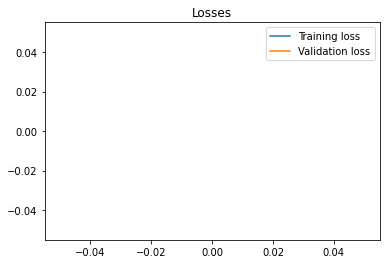

In [173]:
input_dim = X_train_arr.shape[1]
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {
    'input_dim': input_dim,
    'output_dim': output_dim,
    'layer_dim': layer_dim,
    'hidden_dim': hidden_dim,
    'dropout_prob': dropout
}

model = get_model('gru', model_params)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

opt = Optimization(model = model, loss_fn = loss_fn, optimizer = optimizer)
opt.train(train_loader, val_loader, batch_size = batch_size, n_epochs = n_epochs, n_features=input_dim)
opt.plot_losses()

preds, vals = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [174]:
def inverse_transform(scaler, df, columns):
    for c in columns:
        df[c] = scaler.inverse_transform(df[c])
    return df

def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    
    df_result = pd.DataFrame(data={'count': vals, 'prediction': preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [['count', 'prediction']])
    
    return df_result

df_result = format_predictions(preds, vals, X_test, scaler)

<AxesSubplot:xlabel='date'>

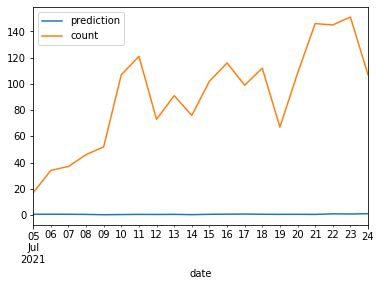

In [175]:
df_result[['prediction', 'count']].plot()

## Baseline

In [176]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df['count'], df.prediction.tolist()),
            'rmse' : mean_squared_error(df['count'], df.prediction) ** 0.5,
            'r2' : r2_score(df['count'], df.prediction)}

result_metrics = calculate_metrics(df_result)

In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def build_baseline_model(df, test_ratio, target_col):
    df_ = df.copy()
    y = df_.pop('count') 
    X = df_
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    print(X_train)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result, model

df_baseline, model = build_baseline_model(df_transformed, 0.2, 'count')
baseline_metrics = calculate_metrics(df_baseline)


            lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  lag10  ...  \
date                                                                     ...   
2021-04-19   9.0   4.0   9.0   1.0  12.0   4.0   4.0   6.0   7.0    5.0  ...   
2021-04-20   4.0   9.0   4.0   9.0   1.0  12.0   4.0   4.0   6.0    7.0  ...   
2021-04-21   7.0   4.0   9.0   4.0   9.0   1.0  12.0   4.0   4.0    6.0  ...   
2021-04-22  15.0   7.0   4.0   9.0   4.0   9.0   1.0  12.0   4.0    4.0  ...   
2021-04-23   5.0  15.0   7.0   4.0   9.0   4.0   9.0   1.0  12.0    4.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
2021-06-30  31.0  16.0  23.0  28.0  28.0  22.0  12.0  19.0   5.0    3.0  ...   
2021-07-01  31.0  31.0  16.0  23.0  28.0  28.0  22.0  12.0  19.0    5.0  ...   
2021-07-02  31.0  31.0  31.0  16.0  23.0  28.0  28.0  22.0  12.0   19.0  ...   
2021-07-03  42.0  31.0  31.0  31.0  16.0  23.0  28.0  28.0  22.0   12.0  ...   
2021-07-04  24.0  42.0  31.0  31.0  31.0

In [178]:
yhat_base = model.predict(df_transformed.drop(columns=['count']).to_numpy())

In [179]:
df_transformed['yhat_base'] = yhat_base

<AxesSubplot:xlabel='date'>

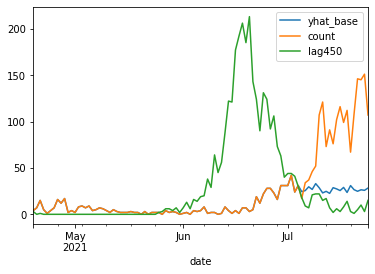

In [184]:
df_transformed[['yhat_base', 'count', 'lag450']].plot()

In [114]:
baseline_metrics

{'mae': 21.661610918256432,
 'rmse': 38.675494965810394,
 'r2': -0.1109192439858182}